In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("sampled_400_sentence_level_no_dedup_latest.csv")

/tmp/ipython-input-3207720989.py:1: DtypeWarning: Columns (1,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("sampled_400_sentence_level_no_dedup_latest.csv")


In [ ]:
df

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,...,review_seq_id,product_name_cleaned,review_count,rank_in_brand,_informative_,author_id_f,sentence_text,sentence_index,n_sentences_in_review,sentence_char_len
0,37899,5148751462,1,0.0,0.333333,3,2,1,2023-02-06,Terrible product ! The foam fall right off you...,...,690007.0,Acne Solutions Cleansing Foam,1043.0,5.0,True,5.148751e+09,Terrible product !,0.0,4.0,18.0
1,37899,5148751462,1,0.0,0.333333,3,2,1,2023-02-06,Terrible product ! The foam fall right off you...,...,690007.0,Acne Solutions Cleansing Foam,1043.0,5.0,True,5.148751e+09,The foam fall right off your hand as soon as i...,1.0,4.0,81.0
2,37899,5148751462,1,0.0,0.333333,3,2,1,2023-02-06,Terrible product ! The foam fall right off you...,...,690007.0,Acne Solutions Cleansing Foam,1043.0,5.0,True,5.148751e+09,It so foamy and lathered that none of it get o...,2.0,4.0,83.0
3,37899,5148751462,1,0.0,0.333333,3,2,1,2023-02-06,Terrible product ! The foam fall right off you...,...,690007.0,Acne Solutions Cleansing Foam,1043.0,5.0,True,5.148751e+09,Waste of money,3.0,4.0,14.0
4,38009,12502464001,1,0.0,0.500000,2,1,1,2019-04-13,Worst ACNE PRODUCT on the market! It made me b...,...,690117.0,Acne Solutions Cleansing Foam,1043.0,5.0,True,1.250246e+10,Worst ACNE PRODUCT on the market!,0.0,3.0,33.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20651,16576,22828834318,5,1.0,1.000000,5,0,5,2021-03-05,Absolutely obsessed with this cleanser. Check ...,...,16577.0,Soy Hydrating Gentle Face Cleanser,8736.0,1.0,True,2.282883e+10,Check out the gorgeous new packaging too!!!,1.0,4.0,43.0
20652,16576,22828834318,5,1.0,1.000000,5,0,5,2021-03-05,Absolutely obsessed with this cleanser. Check ...,...,16577.0,Soy Hydrating Gentle Face Cleanser,8736.0,1.0,True,2.282883e+10,"Not only will your face get a deep cleanse, it...",2.0,4.0,121.0
20653,16576,22828834318,5,1.0,1.000000,5,0,5,2021-03-05,Absolutely obsessed with this cleanser. Check ...,...,16577.0,Soy Hydrating Gentle Face Cleanser,8736.0,1.0,True,2.282883e+10,Absolutely recommend,3.0,4.0,20.0
20654,20077,1595812769,5,NaN,NaN,0,0,0,2017-01-10,I received a sample of this for my birthday an...,...,20078.0,Soy Hydrating Gentle Face Cleanser,8736.0,1.0,True,1.595813e+09,I received a sample of this for my birthday an...,0.0,2.0,58.0


## Data Preprocessing

In [ ]:
#Checking for duplicates
duplicate_rows = df[df.duplicated()]
print(f"duplicate rows：{len(duplicate_rows)}")

duplicate rows：0


In [ ]:
product_groups = df.groupby("product_name_cleaned")
product_names = df["product_name_cleaned"].unique()
print(len(product_names))

14


### Clean for Sbert+Kmeans

In [ ]:
import re
import nltk
import pandas as pd
import numpy as np
from nltk import pos_tag, word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet, opinion_lexicon
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
from sentence_transformers import SentenceTransformer
from collections import defaultdict
import nltk


# === Ensure Necessary NLTK Resources ===
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
nltk.download('opinion_lexicon')
nltk.download('punkt')
nltk.download('punkt_tab') # Note: The newer NLTK version separates punkt_tab


# -------------------------------------------------------
# PART 1: SETUP FOR TEXT PREPROCESSING
# -------------------------------------------------------

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# --- Custom Stopword Lists ---

# 1️⃣ Brand names and high-frequency terms to remove
brand_terms = {"sephora", "clinique","drunk", "elephant", "farmacy","first","aid","beauty","tatcha","ordinary","belif","fresh","dr","dennis", "brand"}
product_terms = {"toner","mask","cleanser","cream","product","serum","eye","vitamin","c","moisturizer"}
common_remove = {"skin","face","makeup","apply","use","make", "get", "try", "go", "would",
    "give", "little", "way", "one","say","feel", "look", "work","put","bottle",
    "think", "see", "find", "need", "want", "take", "help", "buy",
    "receive", "review", "notice", "every", "still", "time", "even","day", "night",
    "much", "never", "long", "without", "felt", "difference", "start",
    "break","month", "week", "routine","bit","leave","however",
    "lot", "enough", "always", "come", "thing", "sure", "nothing",
    "feeling","skincare","water","combination","something", "anything", "everything", "someone", "anyone", "everyone",
                 "else",  "special"}
evaluation_words = {
    "love","amaze","like", "good", "great", "amazing", "awesome", "nice", "perfect",
    "best", "wonderful", "excellent", "fantastic", "recommend", "highly", "definitely","horrible",
    "favorite", "really", "super", "very", "absolutely","worst","right","bad" ,"well","also","terrible"
}
slang_trash = {"lol", "omg", "ugh", "haha", "dude", "whatttt", "nah", "idk", "yesss", "wow", "hmm"}

additional_remove = {
    "kinda", "please", "ever", "since", "likely", "possible", "personally", "actually", "yes", "no", "surely",
    # Operational / Scene words
    "morning", "night", "wake", "keep", "extra", "strength", "around", "nose",
    # Degree adverbs
    "completely", "extremely", "high", "low", "super", "ultra", "very",
    "result", "prevent", "can","not", "think", "know", "seem", "decide", "enjoy", "continue",
    "compare","amount","new", "changer","people", "job", "area","cannot", "wish", "okay", "guess", "wait", "noticeable","follow","change",
    "others","afterwards","several","least","similar","slight","suppose","subtle","doesnt"
}

marketing_terms = {
    "holy", "grail", "influencer", "complimentary", "voxbox",
    "aqua", "bomb", "deluxe", "sample", "honest", "review",
    "alpha", "beta", "test", "purpose", "sponsored", "reviewer"
}


# Use sentiment lexicons to remove purely emotional words
vader_words = set(SentimentIntensityAnalyzer().lexicon.keys())
opinion_words = set(opinion_lexicon.positive()) | set(opinion_lexicon.negative())
emotion_words = vader_words | opinion_words

# === Combine all into a single set ===
custom_remove = (
    brand_terms
    | product_terms
    | evaluation_words
    | common_remove
    | slang_trash
    | marketing_terms
    | additional_remove
    | emotion_words
)
# Make sure to keep some specific terms if they are relevant aspects
custom_remove -= {"smell", "scent", "fragrance", "glowy", "radiant", "shine", "bright", "luminous", "lighten", "brighten"}


# -------------------------------------------------------
# PART 2: HELPER FUNCTIONS FOR PREPROCESSING
# -------------------------------------------------------
def get_wordnet_pos(tag):
    """Converts NLTK POS tags to a format WordNetLemmatizer can use."""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_tokens(tokens):
    """Performs lemmatization based on POS tags."""
    pos_tags = pos_tag(tokens)
    return [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tags
    ]

# -------------------------------------------------------
# PART 3: MAIN CLEANING FUNCTION AND APPLICATION
# -------------------------------------------------------
def clean_text_v3(text):
    """Main function to clean raw text."""
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text))
    tokens = text.lower().split()

    # Lemmatize tokens
    tokens = lemmatize_tokens(tokens)

    # Remove stopwords, custom words, and short words
    tokens = [
        t for t in tokens
        if t not in stop_words
        and t not in custom_remove
        and t.isalpha()
    ]

    # Return the cleaned sentence
    return " ".join(tokens).strip()

# Assuming 'df' is your DataFrame and it has a 'sentence_text' column
# df = pd.read_excel("your_data.xlsx")
df["clean_sentence"] = df["sentence_text"].apply(clean_text_v3)

print(f"✅ Preprocessing complete. {len(df)} sentences ready for aspect extraction.")
print("--- Sample of cleaned sentences ---")
print(df["clean_sentence"].head(10))
print("-" * 35)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


✅ Preprocessing complete. 20656 sentences ready for aspect extraction.
--- Sample of cleaned sentences ---
0                                     
1                       foam soon pump
2                    foamy lather none
3                                money
4                          acne market
5                       small forehead
6                                     
7                                 line
8    previously salicylic acid respond
9                    formula different
Name: clean_sentence, dtype: object
-----------------------------------


### Clean for LDA


In [ ]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 70.6 MB/s eta 0:00:00


In [ ]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag, WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
from collections import Counter

# === 1. Download necessary NLTK resources ===
# (Only needs to be run once)
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

# === 2. Setup for Text Preprocessing ===
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# --- A more conservative and targeted stopword list for LDA ---
brand_terms = {
    "sephora", "clinique", "drunk", "elephant", "farmacy",
    "tatcha", "ordinary", "belif", "fresh", "dennis", "dr"
}
marketing_terms = {
    "holy", "grail", "influenster", "complimentary", "voxbox",
    "aqua", "bomb", "deluxe", "honest", "review",
    "alpha", "beta", "test", "purpose", "sponsored", "reviewer", "sample"
}
slang_trash = {
    "lol", "omg", "ugh", "haha", "dude", "whatttt", "nah", "idk", "yesss", "wow", "hmm"
}
evaluation_words = {
    "love","amaze","like", "good", "great", "amazing", "awesome", "nice", "perfect",
    "best", "wonderful", "excellent", "fantastic", "recommend", "highly", "definitely","horrible",
    "favorite", "really", "super", "very", "absolutely","worst","right","bad" ,"well","also","terrible"
}
common_words = {
    "something", "anything", "everything", "someone", "anyone", "everyone", "thing",
    "im", "ive", "dont", "cant", "wont", "isnt", "wasnt"
}

# 🔹 A smaller, more targeted stopword list specifically for LDA
lda_stopwords = (
    brand_terms
    | marketing_terms
    | slang_trash
    | common_words
    | evaluation_words
)

# === 3. Helper Functions for Lemmatization ===
def get_wordnet_pos(tag):
    """Converts NLTK POS tags to a format WordNetLemmatizer can use."""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_tokens(tokens):
    """Performs lemmatization based on POS tags."""
    pos_tags = pos_tag(tokens)
    return [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        for word, tag in pos_tags
    ]

# === 4. Main Cleaning Function (Less Aggressive Version) ===
def clean_text_for_lda(text):
    """
    A less aggressive cleaning function optimized for LDA.
    Returns a single cleaned string.
    """
    # Keep only alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', ' ', str(text))
    tokens = text.lower().split()

    # Lemmatize first to group word forms
    tokens = lemmatize_tokens(tokens)

    # POS tagging
    pos_tags = pos_tag(tokens)

    # Keep Nouns (NN), Verbs (VB), and Adjectives (JJ)
    tokens = [
        word for word, pos in pos_tags
        if (pos.startswith('NN') or   # Nouns
            pos.startswith('VB') or   # Verbs
            pos.startswith('JJ')) and # Adjectives
           word not in stop_words and    # Basic NLTK stopwords
           word not in lda_stopwords and # Custom targeted stopwords
           word.isalpha() and
           len(word) > 2               # At least 3 letters
    ]

    return " ".join(tokens)

# === 5. Streamlined Cleaning and N-gram Application ===

# Assuming 'df' is your DataFrame and has a 'sentence_text' column
# df = pd.read_excel("your_data.xlsx")

print("Processing text to create the 'clean_sentence_lda' column...")

# Step 5.1: Perform initial text cleaning.
# This creates a temporary Series; it's not added to the df yet.
print("   - Performing initial text cleaning...")
cleaned_sentences = df['sentence_text'].apply(clean_text_for_lda)

# Step 5.2: Train n-gram models from the cleaned text.
print("   - Training n-gram models...")
sentences_for_ngram_training = [s.split() for s in cleaned_sentences if s]
bigram = Phrases(sentences_for_ngram_training, min_count=5, threshold=10)
trigram = Phrases(bigram[sentences_for_ngram_training], threshold=10)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Step 5.3: Apply the trained n-gram models to the cleaned text.
print("   - Applying n-grams to create the final sentences...")
def apply_ngrams(sentence_text, model):
    tokens = sentence_text.split()
    ngram_tokens = model[tokens]
    return " ".join(ngram_tokens)

final_sentences_with_ngrams = cleaned_sentences.apply(lambda s: apply_ngrams(s, trigram_mod))

# Step 5.4: Add the single, final column to the DataFrame.
df['clean_sentence_lda'] = final_sentences_with_ngrams


# === 6. Final Output Review ===
print(f"\n Processing complete!")
print("A single new column 'clean_sentence_lda' has been added to the DataFrame.")

# --- Before and After Comparison ---
print("\n Before and After Cleaning Examples:")
for idx in df.head(5).index:
    original_text = df.loc[idx, 'sentence_text']
    cleaned_text = df.loc[idx, 'clean_sentence_lda']
    print(f"\nOriginal: {original_text[:90]}...")
    print(f"Cleaned : {cleaned_text}")

# --- Check the most common words in the final column ---
all_words = " ".join(df['clean_sentence_lda']).split()
word_freq = Counter(all_words)

print("\n Top 20 Most Frequent Terms in 'clean_sentence_lda':")
for word, count in word_freq.most_common(20):
    print(f"{word}: {count}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processing text to create the 'clean_sentence_lda' column...
   - Performing initial text cleaning...
   - Training n-gram models...
   - Applying n-grams to create the final sentences...

 Processing complete!
A single new column 'clean_sentence_lda' has been added to the DataFrame.

 Before and After Cleaning Examples:

Original: Terrible product !...
Cleaned : product

Original: The foam fall right off your hand as soon as it goes from the pump to your face ....
Cleaned : foam fall hand pump face

Original: It so foamy and lathered that none of it get on your face Does absolutely nothing !...
Cleaned : foamy lather none get face nothing

Original: Waste of money...
Cleaned : waste_money

Original: Worst ACNE PRODUCT on the market!...
Cleaned : acne product market

 Top 20 Most Frequent Terms in 'clean_sentence_lda':
skin: 21128
use: 12125
product: 11827
face: 6131
feel: 5603
dry: 5087
make: 4428
get: 4052
try: 3550
moisturizer: 3070
look: 2956
work: 2847
sensitive: 2403
leave: 2391


In [ ]:
df

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,...,review_count,rank_in_brand,_informative_,author_id_f,sentence_text,sentence_index,n_sentences_in_review,sentence_char_len,clean_sentence,clean_sentence_lda
0,37899,5148751462,1,0.0,0.333333,3,2,1,2023-02-06,Terrible product ! The foam fall right off you...,...,1043,5,True,5148751462,Terrible product !,0,4,18,,product
1,37899,5148751462,1,0.0,0.333333,3,2,1,2023-02-06,Terrible product ! The foam fall right off you...,...,1043,5,True,5148751462,The foam fall right off your hand as soon as i...,1,4,81,foam soon pump,foam fall hand pump face
2,37899,5148751462,1,0.0,0.333333,3,2,1,2023-02-06,Terrible product ! The foam fall right off you...,...,1043,5,True,5148751462,It so foamy and lathered that none of it get o...,2,4,83,foamy lather none,foamy lather none get face nothing
3,37899,5148751462,1,0.0,0.333333,3,2,1,2023-02-06,Terrible product ! The foam fall right off you...,...,1043,5,True,5148751462,Waste of money,3,4,14,money,waste_money
4,38009,12502464001,1,0.0,0.500000,2,1,1,2019-04-13,Worst ACNE PRODUCT on the market! It made me b...,...,1043,5,True,12502464001,Worst ACNE PRODUCT on the market!,0,3,33,acne market,acne product market
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69952,86143,26753085258,5,1.0,0.800000,5,1,4,2021-08-22,"For the first few months, I didn’t really noti...",...,5795,1,True,26753085258,Unfortunately it hasn’t noticeably changed the...,3,8,100,noticeably size pore,change size pore sure product
69953,86143,26753085258,5,1.0,0.800000,5,1,4,2021-08-22,"For the first few months, I didn’t really noti...",...,5795,1,True,26753085258,Will be rebuying based on the lack of break ou...,4,8,58,rebuying base,rebuying base lack break sure
69954,86143,26753085258,5,1.0,0.800000,5,1,4,2021-08-22,"For the first few months, I didn’t really noti...",...,5795,1,True,26753085258,After cleansing I apply this followed by Buffe...,5,8,90,cleanse buffet moisturiser spf,cleanse apply follow buffet moisturiser spf
69955,86143,26753085258,5,1.0,0.800000,5,1,4,2021-08-22,"For the first few months, I didn’t really noti...",...,5795,1,True,26753085258,I also use the granactive retinoid in the eve.,6,8,46,granactive retinoid eve,use granactive retinoid eve


In [ ]:
from collections import Counter
from itertools import chain

top_words = Counter(chain.from_iterable(df["clean_sentence"].str.split())).most_common(50)
print(top_words)


[('dry', 5345), ('smell', 2720), ('oily', 2575), ('acne', 2289), ('hydrate', 1696), ('pore', 1513), ('price', 1446), ('wash', 1316), ('texture', 1270), ('remove', 1233), ('oil', 1152), ('scent', 1116), ('moisturize', 1088), ('light', 1075), ('breakout', 1067), ('purchase', 1051), ('cleanse', 1042), ('size', 970), ('balm', 964), ('last', 797), ('stuff', 786), ('year', 781), ('winter', 739), ('small', 730), ('though', 727), ('prone', 716), ('cause', 696), ('away', 694), ('scrub', 691), ('two', 687), ('back', 670), ('ingredient', 667), ('heavy', 662), ('many', 646), ('could', 633), ('wear', 631), ('less', 615), ('repurchase', 596), ('peel', 585), ('far', 582), ('foundation', 582), ('fragrance', 570), ('absorb', 567), ('add', 560), ('moisture', 559), ('line', 555), ('quickly', 554), ('mix', 547), ('full', 537), ('daily', 531)]


## SBert + Kmeans

In [ ]:

import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip install bertopic sentence-transformers



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.8 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
import re
import nltk
import pandas as pd
from nltk import pos_tag, word_tokenize
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
import numpy as np
from sentence_transformers import SentenceTransformer


nltk.download('punkt')
nltk.download('punkt_tab')  # Note: The newer NLTK version separates punkt_tab
nltk.download('wordnet')
nltk.download('omw-1.4')


#1. Extract Nouns / Adjectives / Bigrams

def extract_nouns_adjs_bigrams(text):
    """
    Extracts nouns, adjectives, and adjacent bigrams from a given text.
    """
    if not isinstance(text, str) or not text.strip():
        return []
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    keep = []

    # Keep nouns (NN) and adjectives (JJ)
    for i, (word, tag) in enumerate(pos_tags):
        if tag.startswith("NN") or tag.startswith("JJ"):
            if len(word) > 2:
                keep.append(word)

    # Add adjacent bigrams (e.g., hydrating cream, strong scent)
    for i in range(len(words) - 1):
        a, b = words[i], words[i + 1]
        if len(a) > 2 and len(b) > 2:
            bigram = f"{a}_{b}"
            keep.append(bigram)

    return keep

#2.  Apply Term Extraction to Cleaned Sentences

df_terms = df.copy()
df_terms["tokens"] = df_terms["clean_sentence"].apply(extract_nouns_adjs_bigrams)

# Filter out sentences with no tokens
df_terms = df_terms[df_terms["tokens"].apply(lambda x: len(x) > 0)].reset_index(drop=True)

# Flatten into a single term list (for visualization)
all_terms = [t for tokens in df_terms["tokens"] for t in tokens if isinstance(t, str)]
print(f"A total of {len(all_terms):,} terms were extracted.")


# 3️. Term Vectorization (SBERT priority; fallback to TF-IDF char n-gram)
def embed_texts(texts, model="BAAI/bge-large-en-v1.5"):
    """
    Encodes a list of texts into vector embeddings using SentenceTransformers,
    with a TF-IDF fallback.
    """
    try:
        from sentence_transformers import SentenceTransformer
        mdl = SentenceTransformer(model)
        X = mdl.encode(texts, batch_size=256, normalize_embeddings=True, show_progress_bar=True)
        return np.asarray(X, dtype=float), "sbert"
    except Exception:
        print("⚠️ SBERT loading failed, falling back to TF-IDF char n-gram.")
        vec = TfidfVectorizer(analyzer="char", ngram_range=(2, 4), min_df=1)
        X = vec.fit_transform(texts)
        return X, "tfidf-char"

# Create a term frequency dictionary
dfreq = pd.Series(all_terms).value_counts().to_dict()

# Get the unique vocabulary (avoids duplicate terms)
vocab_terms = list(set(all_terms))
X_terms, backend = embed_texts(vocab_terms)
print(f"Term vector backend: {backend} | Shape: {getattr(X_terms,'shape',None)}")

# 4. Unsupervised Clustering: Grouping terms into 6 clusters (aspects)
from collections import defaultdict

N_ASPECTS = 6
kmt = MiniBatchKMeans(
    n_clusters=N_ASPECTS,
    random_state=2022,
    n_init=10,
    batch_size=512,
    max_iter=400
)
term_labels = kmt.fit_predict(X_terms)

# For each cluster, select a representative term and synonyms (top 10 by frequency)
clusters = defaultdict(list)
for t, lab in zip(vocab_terms, term_labels):
    clusters[lab].append(t)

aspect_names = {}
aspect_terms = {}
for lab, ts in clusters.items():
    head = sorted(ts, key=lambda x: dfreq.get(x, 0), reverse=True)[:10]
    aspect_names[lab] = head[0]      # Representative name
    aspect_terms[lab] = head         # Top ten terms within the cluster

print("\n=== Six Aspects (Auto-named + Synonyms within Cluster) ===")
for lab in sorted(aspect_names):
    print(f"{lab}: {aspect_names[lab]} | Synonyms: {', '.join(aspect_terms[lab])}")


# 5️. Find Example Sentences for Each Cluster's Representative Term
for i in sorted(aspect_names):
    examples = df_terms[df_terms["clean_sentence"].str.contains(aspect_names[i], case=False, na=False)]["clean_sentence"].head(3).tolist()
    print(f"\n🟩 Aspect {i}: {aspect_names[i]}")
    print("Synonyms:", ", ".join(aspect_terms[i]))
    print("Example Sentences:")
    for ex in examples:
        print(" -", ex)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


A total of 359,858 terms were extracted.


Batches:   0%|          | 0/447 [00:00<?, ?it/s]

Term vector backend: sbert | Shape: (114245, 1024)

=== Six Aspects (Auto-named + Synonyms within Cluster) ===
0: hydrate | Synonyms: hydrate, cleanse, moisture, hydration, dewy, spray, absorb, cleanse_balm, dry_patch, mist
1: dry | Synonyms: dry, sensitive, smell, clean, soft, price, texture, wash, oil, scent
2: remover | Synonyms: remover, dark_circle, fine_line, ultra_repair, irritate_sensitive, job_remove, large_size, minimize_pore, mini_size, small_size
3: glowy | Synonyms: glowy, dark_spot, huge_fan, rise_petal, high_hope, sit_top, big_fan, extremely_sensitive, stuff_amaze, especially_winter
4: acne | Synonyms: acne, balm, moisturize, acne_prone, peel, moisturizers, redness, exfoliate, retinol, mascara
5: repurchase | Synonyms: repurchase, full_size, price_point, can_not, worth_price, light_weight, worth_money, small_amount, price_tag, waste_money

🟩 Aspect 0: hydrate
Synonyms: hydrate, cleanse, moisture, hydration, dewy, spray, absorb, cleanse_balm, dry_patch, mist
Example Sente

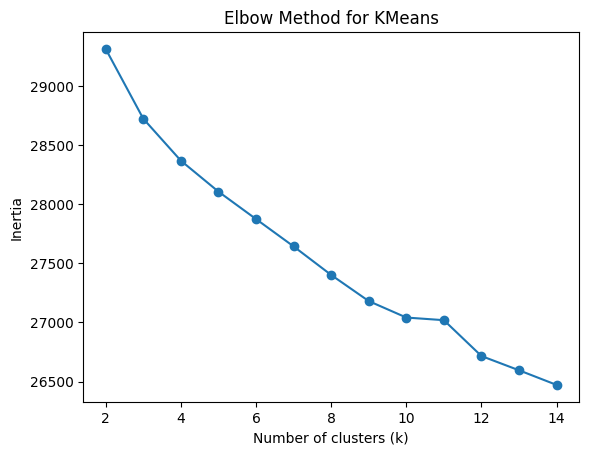

k=2->3: ΔInertia = -590.12
k=3->4: ΔInertia = -354.85
k=4->5: ΔInertia = -261.83
k=5->6: ΔInertia = -232.00
k=6->7: ΔInertia = -231.21
k=7->8: ΔInertia = -241.53
k=8->9: ΔInertia = -220.99
k=9->10: ΔInertia = -139.31
k=10->11: ΔInertia = -22.32
k=11->12: ΔInertia = -303.30
k=12->13: ΔInertia = -120.45
k=13->14: ΔInertia = -123.81


In [ ]:
inertias = []
for k in range(2, 15):
    km = MiniBatchKMeans(n_clusters=k, random_state=42)
    km.fit(X_terms)
    inertias.append(km.inertia_)

plt.plot(range(2, 15), inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for KMeans')
plt.show()

# Calculate the change in slope (delta) between each k
slopes = []
for i in range(1, len(inertias)):
    slope = inertias[i] - inertias[i-1]
    slopes.append(slope)

for k, s in zip(range(3, 15), slopes):  # Corresponds to the slope starting from k=3
    print(f"k={k-1}->{k}: ΔInertia = {s:.2f}")


## Refined clusters

In [ ]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Define refined clusters and label map
refined_clusters = {
    1: ["dry", "hydrate", "moisture", "hydration", "absorb", "dewy", "hydrating"],
    2: ["price", "repurchase", "price_point", "worth", "value", "spend", "money"],
    3: ["glowy", "radiant", "shine", "bright", "luminous", "lighten", "brighten", "skin_glow"],
    4: ["smell", "scent", "fragrance", "odor"],

    5: ["acne", "break","balm", "redness", "peel", "exfoliate", "retinol",
        "breakout", "break_out", "pimple", "blemish", "irritation",
        "break_odd"],

    6: ["full_size", "mini", "sample", "packaging", "bottle",
        "jar", "pump", "dispenser", "container", "travel_size", "tube"],

7: ["work", "result", "impressed", "glad", "effective", "hate",
        "amazing", "love", "staple", "fan", "holy_grail", "happy_purchase",
        "product_know_special", "item_teenager_daughter", "buy_teenage_daughter",
        "soap", "bar_soap"],

    8: ["morning", "night", "day", "routine", "everyday", "week", "month", "apply", "use"],

    9: ["purchase", "buy", "order", "store", "return", "refund", "exchange"]
}

label_map = {
    0: "unassigned",
    1: "dry_hydrate",
    2: "price_value",
    3: "glowy_appearance",
    4: "smell_scent",
    5: "acne_effect",
    6: "packaging_size",
    7: "general_effect",
    8: "usage_routine",
    9: "purchase_return"
}


# Load SBERT model
model = SentenceTransformer("BAAI/bge-large-en-v1.5")


# Create centroids for each cluster
refined_centroids = {
    cid: np.mean(model.encode(terms, normalize_embeddings=True), axis=0)
    for cid, terms in refined_clusters.items()
}

# Set parameters and clean data
SIMILARITY_THRESHOLD = 0.5
MIN_WORDS = 3

df["clean_sentence_lda"] = df["clean_sentence_lda"].fillna("").astype(str)

# Calculate similarity and perform full classification (9+1 topics)

mask_valid = (
    df["clean_sentence_lda"].str.strip().astype(bool) &
    (df["clean_sentence_lda"].str.split().str.len() >= MIN_WORDS)
)

#  Column for the original 9+1 topic classification
df["global_topic_id_orig"] = 0
df["global_topic_similarity"] = 0.0

if mask_valid.sum() > 0:
    sentence_embeddings = model.encode(
        df.loc[mask_valid, "clean_sentence_lda"].tolist(),
        normalize_embeddings=True,
        show_progress_bar=True
    )

    assignments = []
    for sent_vec in sentence_embeddings:
        sims = {cid: cosine_similarity([sent_vec], [cent])[0][0]
                for cid, cent in refined_centroids.items()}
        top_cluster = max(sims, key=sims.get)
        top_similarity = sims[top_cluster]

        if top_similarity < SIMILARITY_THRESHOLD:
            assignments.append((0, top_similarity))
        else:
            assignments.append((top_cluster, top_similarity))

    df.loc[mask_valid, "global_topic_id_orig"] = [a[0] for a in assignments]
    df.loc[mask_valid, "global_topic_similarity"] = [a[1] for a in assignments]

df.loc[~mask_valid, "global_topic_id_orig"] = 0
df.loc[~mask_valid, "global_topic_similarity"] = 0.0

df["global_topic_id_orig"] = df["global_topic_id_orig"].astype(int)
df["global_topic_name_orig"] = df["global_topic_id_orig"].map(label_map)
print("Classification complete.")

# 6+1 topic columns for LDA analysis
df['global_topic_id'] = df['global_topic_id_orig']

# Re-assign auxiliary topics (7, 8, 9) to 0 (unassigned) in the new column
auxiliary_topics = [7, 8, 9]
df.loc[df['global_topic_id'].isin(auxiliary_topics), 'global_topic_id'] = 0

# Create the corresponding name column
df['global_topic_name'] = df['global_topic_id'].map(label_map)
print("LDA-specific columns created.")


print(f"\n--- Final Result Check ---")
print(f"Total sentences: {len(df)}")
print(f"Valid sentences (>={MIN_WORDS} words): {mask_valid.sum()}")
print(f"Short/Empty sentences: {(~mask_valid).sum()}")


# Final handover update: Using new column names
df_for_lda = df[df['global_topic_id'] != 0].copy()
print(f"\n Final data for LDA contains: {len(df_for_lda)} sentences")

Batches:   0%|          | 0/1604 [00:00<?, ?it/s]

Classification complete.
LDA-specific columns created.

--- Final Result Check ---
Total sentences: 69957
Valid sentences (>=3 words): 51298
Short/Empty sentences: 18659

 Final data for LDA contains: 41565 sentences


In [ ]:
df

,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,...,sentence_index,n_sentences_in_review,sentence_char_len,clean_sentence,clean_sentence_lda,global_topic_id_orig,global_topic_similarity,global_topic_name_orig,global_topic_id,global_topic_name
0,37899,5148751462,1,0.0,0.333333,3,2,1,2023-02-06,Terrible product ! The foam fall right off you...,...,0,4,18,,product,0,0.000000,unassigned,0,unassigned
1,37899,5148751462,1,0.0,0.333333,3,2,1,2023-02-06,Terrible product ! The foam fall right off you...,...,1,4,81,foam soon pump,foam fall hand pump face,6,0.632472,packaging_size,6,packaging_size
2,37899,5148751462,1,0.0,0.333333,3,2,1,2023-02-06,Terrible product ! The foam fall right off you...,...,2,4,83,foamy lather none,foamy lather none get face nothing,5,0.595255,acne_effect,5,acne_effect
3,37899,5148751462,1,0.0,0.333333,3,2,1,2023-02-06,Terrible product ! The foam fall right off you...,...,3,4,14,money,waste_money,0,0.000000,unassigned,0,unassigned
4,38009,12502464001,1,0.0,0.500000,2,1,1,2019-04-13,Worst ACNE PRODUCT on the market! It made me b...,...,0,3,33,acne market,acne product market,5,0.596177,acne_effect,5,acne_effect
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69952,86143,26753085258,5,1.0,0.800000,5,1,4,2021-08-22,"For the first few months, I didn’t really noti...",...,3,8,100,noticeably size pore,change size pore sure product,5,0.696049,acne_effect,5,acne_effect
69953,86143,26753085258,5,1.0,0.800000,5,1,4,2021-08-22,"For the first few months, I didn’t really noti...",...,4,8,58,rebuying base,rebuying base lack break sure,2,0.713823,price_value,2,price_value
69954,86143,26753085258,5,1.0,0.800000,5,1,4,2021-08-22,"For the first few months, I didn’t really noti...",...,5,8,90,cleanse buffet moisturiser spf,cleanse apply follow buffet moisturiser spf,5,0.649337,acne_effect,5,acne_effect
69955,86143,26753085258,5,1.0,0.800000,5,1,4,2021-08-22,"For the first few months, I didn’t really noti...",...,6,8,46,granactive retinoid eve,use granactive retinoid eve,5,0.707874,acne_effect,5,acne_effect


In [ ]:

output_path = "sbert_kmeans.xlsx"

df_export = df.drop(columns=["clean_sentence","clean_sentence_lda_ngrams","global_topic_similarity","global_topic_id_orig","global_topic_name_orig","word_count_lda",
"clean_sentence_lda_ngrams","tokens_for_lda","tokens_with_ngrams"], errors="ignore")
df_export.to_excel(output_path, index=False)